In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca

ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
In file included from /home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:21:
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp: In function ‘int Compile(const char*, const char*, int, int, const char*)’:
<command-line>: error: ‘nvrtcGetCUBINSize’ was not declared in this scope
/home/beams0/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/keopscore/include/utils_pe.h:6:26: note: in definition of macro ‘NVRTC_SAFE_CALL’
     nvrtcResult result = x;                                       \
                          ^
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:90:21: note: in expansion of macro ‘nvrtcGetTARGETSize’
     NVRTC_SAFE_CALL(nvrtcGetTA

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
DEFAULT_RANDOM_SEED

75764

In [5]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["kl_divergence", "negative_log_peak_intensity", "peak_distance"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm": 0.02},
        }

In [6]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

    new_dir = work_dir / f"work_dir_{DEFAULT_RANDOM_SEED}"
    new_dir.mkdir(exist_ok=True)

    files = work_dir.glob("*")
    for f in files:
        if f.is_file():
            shutil.copy2(f, new_dir)
    os.chdir(new_dir)

In [7]:
def print_beam_attributes(cp, loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda dw: -np.log(opt_common._get_peak_intensity_from_dw(dw)),
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(
            opt_common._get_weighted_sum_intensity_from_hist(cp, hist, 2)
        ),
        "kl_divergence": lambda hist: opt_common._get_kl_divergence_with_gaussian_from_hist(cp, hist),
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [8]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange=[-detector_x / 2, detector_x / 2],
    yrange=[-detector_y / 2, detector_y / 2],
    nbins_h=1024,
    nbins_v=1024,
    use_denoised=False,
    random_seed=111,
    add_noise=True,
    calculate_over_noise=False,
    noise_threshold=1.5,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
)

xrange_plot = [x / 5 for x in cp.xrange]
yrange_plot = [y / 5 for y in cp.yrange]

ppm = opt_common.PlotParameters(
    xrange=xrange_plot, yrange=yrange_plot, nbins_h=cp.nbins_h // 5, nbins_v=cp.nbins_v // 5
)  # xrange=xrange_plot, yrange=yrange_plot)#, )

In [9]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [10]:
opt_params = OptimizationParameters()


print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['kl_divergence', 'negative_log_peak_intensity', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [11]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


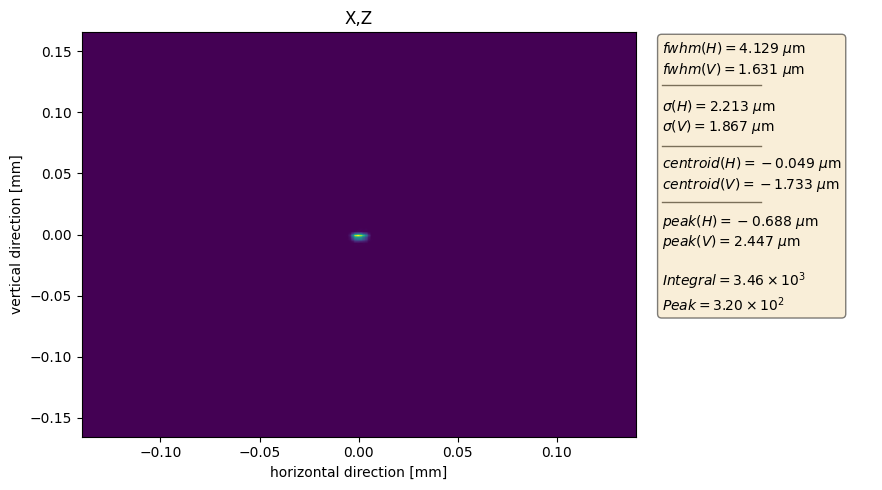

In [12]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [13]:
attribs_focus = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist, dw, "Focused beam")

Focused beam system kl_divergence: 1.331e+00
Focused beam system negative_log_peak_intensity: -5.762e+00
Focused beam system peak_distance: 1.063e-03


In [14]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)

Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [15]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-159.9, -149.8, 0.17248733853924986, 0.0156, 421.80000000000007, 0.17083733853924987, -0.0119]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [8.089307871289733, 11.176168140342014, -0.0005651535118511371, 0.007789939979486966, 2.7699577505968946, -0.001047549494769518, -0.011852636368632468]


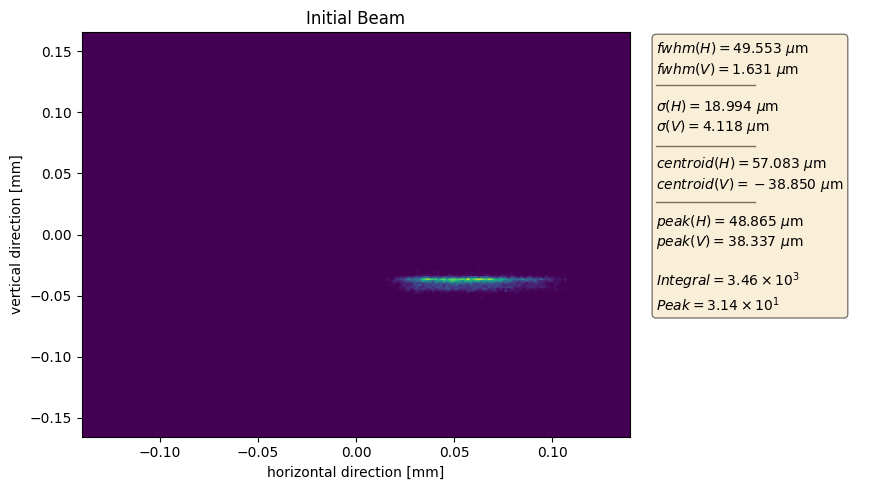

Perturbed beam system kl_divergence: 1.342e+00
Perturbed beam system negative_log_peak_intensity: -3.519e+00
Perturbed beam system peak_distance: 7.709e-02


In [16]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

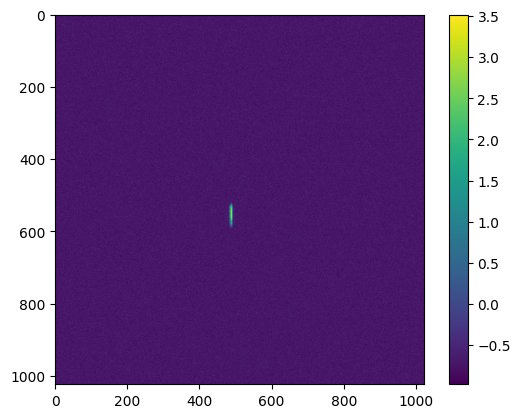

In [17]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [18]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### KL Divergence without remomving noise

In [29]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

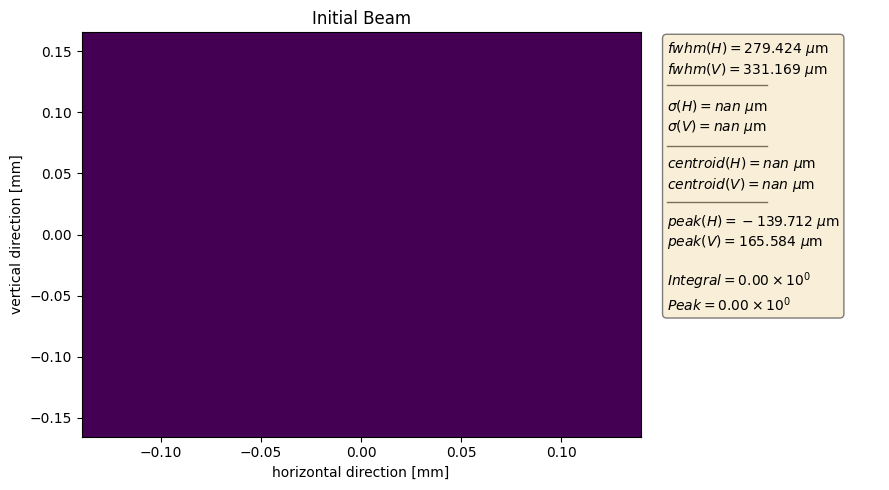

In [30]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [31]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.342e+00
Perturbed beam system negative_log_peak_intensity: -3.829e+00


In [40]:
opt_params = OptimizationParameters()

In [41]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (5e-3, 5e-3)},
)

In [42]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [43]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-22 15:36:01,876] A new study created in memory with name: no-name-12b5508a-e9b4-4ec4-a7a9-5511bddd007e


In [44]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-22 15:36:08,817] Trial 0 finished with values: [1.3416151278847717, -3.8272319276673685] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:16,202] Trial 1 finished with values: [1.3415850260346904, -2.2794153967043123] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:23,307] Trial 2 finished with values: [1.3416087512686647, -2.262569725407809] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:31,230] Trial 3 finished with values: [1.3416012981272296, -2.0087878560736194] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:38,827] Trial 4 finished with values: [1.3416280344822322, -2.1599926231352113] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:45,665] Trial 5 finished with values: [1.341603933973071, -3.2667503063230945] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:52,793] Trial 6 finished with values: [1.341617991042234, -3.628128471758425] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:59,619] Trial 7 finished with values: [1.3416059859702798, -2.6618799687903105] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:06,805] Trial 8 finished with values: [1.3416088134524449, -3.025009473378371] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:14,070] Trial 9 finished with values: [1.3416146825128352, -2.779989228618055] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:22,872] Trial 10 finished with values: [1.3416107166069893, -2.8262891228691456] and parameters: {'hb_1': 11.0, 'hb_2': -13.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.014400000000000003, 'vb_bender': 1.0, 'vb_pitch': -0.00112, 'vb_trans': -0.0184}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:32,489] Trial 11 finished with values: [1.3416126785911442, -4.652996491337063] and parameters: {'hb_1': -11.0, 'hb_2': -10.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.005600000000000001, 'vb_bender': -2.0, 'vb_pitch': -0.00066, 'vb_trans': 0.026900000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:41,505] Trial 12 finished with values: [1.3416134170792418, -3.0751302588435916] and parameters: {'hb_1': -18.0, 'hb_2': -11.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.0097, 'vb_bender': 4.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': 0.029200000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:50,810] Trial 13 finished with values: [1.3415772833730946, -1.2691305226829939] and parameters: {'hb_1': 10.0, 'hb_2': -3.0, 'hb_pitch': 0.001, 'hb_trans': 0.0007000000000000027, 'vb_bender': -4.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.025800000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:00,796] Trial 14 finished with values: [1.3415875361959029, -2.7228406351762664] and parameters: {'hb_1': -3.0, 'hb_2': -3.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.014900000000000004, 'vb_bender': -8.0, 'vb_pitch': 0.0, 'vb_trans': 0.028600000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:10,293] Trial 15 finished with values: [1.3416106022346377, -3.6575568405114485] and parameters: {'hb_1': 2.0, 'hb_2': -1.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.009900000000000006, 'vb_bender': -4.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.025800000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specif

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:20,153] Trial 16 finished with values: [1.3415947929310856, -3.4387208482911618] and parameters: {'hb_1': -11.0, 'hb_2': -9.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.0022000000000000006, 'vb_bender': -11.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': 0.022000000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:29,639] Trial 17 finished with values: [1.3415850725067877, -2.5987690857280494] and parameters: {'hb_1': -1.0, 'hb_2': 1.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.004500000000000004, 'vb_bender': -13.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': 0.023900000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:40,973] Trial 18 finished with values: [1.3416015814232645, -3.02053108128998] and parameters: {'hb_1': -7.0, 'hb_2': -3.0, 'hb_pitch': 0.0, 'hb_trans': 0.006400000000000003, 'vb_bender': -10.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': 0.0216}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:51,706] Trial 19 finished with values: [1.3415910125242665, -2.0565751589004075] and parameters: {'hb_1': 3.0, 'hb_2': -14.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.011300000000000004, 'vb_bender': -16.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': 0.025400000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:02,034] Trial 20 finished with values: [1.3416332320422797, -3.846458482374577] and parameters: {'hb_1': -7.0, 'hb_2': -17.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0050000000000000044, 'vb_bender': -2.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': 0.017100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:11,975] Trial 21 finished with values: [1.3416056629267084, -3.5465028939865646] and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': 0.0005, 'hb_trans': -0.004899999999999998, 'vb_bender': -8.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': 0.0291}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:21,706] Trial 22 finished with values: [1.3416353325997579, -2.9812431172883733] and parameters: {'hb_1': -9.0, 'hb_2': -2.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.004099999999999996, 'vb_bender': -14.0, 'vb_pitch': -0.00056, 'vb_trans': 0.020100000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:31,961] Trial 23 finished with values: [1.3416176001134046, -4.587748881107863] and parameters: {'hb_1': -6.0, 'hb_2': 6.0, 'hb_pitch': -0.0013, 'hb_trans': 0.007900000000000004, 'vb_bender': -4.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': 0.028800000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:42,545] Trial 24 finished with values: [1.3416074400161557, -4.54547423000716] and parameters: {'hb_1': -4.0, 'hb_2': 5.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.0068000000000000005, 'vb_bender': -5.0, 'vb_pitch': 0.0010600000000000002, 'vb_trans': 0.024400000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specifie

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:51,849] Trial 25 finished with values: [1.3415858982001665, -4.005371554627944] and parameters: {'hb_1': -7.0, 'hb_2': -7.0, 'hb_pitch': -0.0016, 'hb_trans': 0.0021000000000000046, 'vb_bender': 0.0, 'vb_pitch': 0.0010600000000000002, 'vb_trans': 0.023000000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:02,474] Trial 26 finished with values: [1.3416050102235526, -3.967893511219511] and parameters: {'hb_1': -1.0, 'hb_2': 9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.006100000000000001, 'vb_bender': -1.0, 'vb_pitch': 0.0011000000000000003, 'vb_trans': 0.029700000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specifie

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:13,609] Trial 27 finished with values: [1.3415956812198049, -2.7612100024582653] and parameters: {'hb_1': -1.0, 'hb_2': -10.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.0019000000000000059, 'vb_bender': -7.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': 0.027300000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spe

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:25,492] Trial 28 finished with values: [1.341615906453714, -4.217088031664808] and parameters: {'hb_1': -1.0, 'hb_2': 4.0, 'hb_pitch': -0.0009, 'hb_trans': 0.010700000000000001, 'vb_bender': -1.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': 0.028700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:36,409] Trial 29 finished with values: [1.3415936900259418, -3.937511209917033] and parameters: {'hb_1': -7.0, 'hb_2': -7.0, 'hb_pitch': -0.0005, 'hb_trans': 0.0031000000000000055, 'vb_bender': -3.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': 0.027200000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:47,628] Trial 30 finished with values: [1.341624667699771, -3.98742670578107] and parameters: {'hb_1': -8.0, 'hb_2': 4.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0040999999999999995, 'vb_bender': -4.0, 'vb_pitch': -0.00118, 'vb_trans': 0.028300000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:59,614] Trial 31 finished with values: [1.3416042441930065, -4.446407199195232] and parameters: {'hb_1': -10.0, 'hb_2': -17.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.013900000000000003, 'vb_bender': -3.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': 0.029300000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:11,194] Trial 32 finished with values: [1.3416142188026103, -3.4635252923827644] and parameters: {'hb_1': -2.0, 'hb_2': -4.0, 'hb_pitch': -0.0014, 'hb_trans': 0.009500000000000001, 'vb_bender': 1.0, 'vb_pitch': 0.00152, 'vb_trans': 0.0165}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:22,580] Trial 33 finished with values: [1.341620598746213, -4.430447029769917] and parameters: {'hb_1': -5.0, 'hb_2': 8.0, 'hb_pitch': 0.0, 'hb_trans': -0.003599999999999999, 'vb_bender': -2.0, 'vb_pitch': 0.0006000000000000003, 'vb_trans': 0.026400000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:32,336] Trial 34 finished with values: [1.3416131933288162, -4.336966128455391] and parameters: {'hb_1': -12.0, 'hb_2': -3.0, 'hb_pitch': -0.0018, 'hb_trans': 0.0143, 'vb_bender': -2.0, 'vb_pitch': 0.0003600000000000001, 'vb_trans': 0.019700000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:44,028] Trial 35 finished with values: [1.3416056474420535, -4.035371908341394] and parameters: {'hb_1': -14.0, 'hb_2': -14.0, 'hb_pitch': -0.0014, 'hb_trans': 0.0032000000000000015, 'vb_bender': 3.0, 'vb_pitch': 0.00116, 'vb_trans': 0.029200000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:56,184] Trial 36 finished with values: [1.3402590756520756, -3.381965609588921] and parameters: {'hb_1': -13.0, 'hb_2': -17.0, 'hb_pitch': -0.0018, 'hb_trans': 0.0009000000000000015, 'vb_bender': -2.0, 'vb_pitch': 0.0009200000000000002, 'vb_trans': 0.026500000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:05,329] Trial 37 finished with values: [1.3416078576601231, -4.621616952387998] and parameters: {'hb_1': -10.0, 'hb_2': -15.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.007600000000000003, 'vb_bender': 0.0, 'vb_pitch': 0.00034, 'vb_trans': 0.028100000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:13,945] Trial 38 finished with values: [1.3415968966454093, -4.939639812741813] and parameters: {'hb_1': -11.0, 'hb_2': -16.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.0155, 'vb_bender': 1.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': 0.0262}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:26,192] Trial 39 finished with values: [1.3416205753950086, -4.654746464075492] and parameters: {'hb_1': -11.0, 'hb_2': -21.0, 'hb_pitch': -0.0005, 'hb_trans': 0.009900000000000006, 'vb_bender': 2.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': 0.017100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:39,984] Trial 40 finished with values: [1.3416102393613303, -4.499333728591219] and parameters: {'hb_1': -10.0, 'hb_2': -21.0, 'hb_pitch': -0.002, 'hb_trans': 0.0058, 'vb_bender': 3.0, 'vb_pitch': 0.0007800000000000003, 'vb_trans': 0.023600000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:52,033] Trial 41 finished with values: [1.3415950075024405, -4.391330756685709] and parameters: {'hb_1': -10.0, 'hb_2': -14.0, 'hb_pitch': -0.0009, 'hb_trans': 0.013700000000000004, 'vb_bender': 2.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.027100000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:05,129] Trial 42 finished with values: [1.3416255216169979, -4.502132662097629] and parameters: {'hb_1': -10.0, 'hb_2': -17.0, 'hb_pitch': -0.0016, 'hb_trans': 0.011300000000000004, 'vb_bender': 1.0, 'vb_pitch': -0.0006199999999999999, 'vb_trans': 0.012200000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:17,164] Trial 43 finished with values: [1.341602479733225, -3.7752261755550083] and parameters: {'hb_1': -9.0, 'hb_2': -23.0, 'hb_pitch': -0.0016, 'hb_trans': 0.0075, 'vb_bender': 4.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': 0.0296}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:32,133] Trial 44 finished with values: [1.3415962065875418, -3.8801102777479173] and parameters: {'hb_1': -13.0, 'hb_2': -24.0, 'hb_pitch': -0.002, 'hb_trans': 0.008600000000000003, 'vb_bender': -3.0, 'vb_pitch': -0.00098, 'vb_trans': 0.023200000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:46,485] Trial 45 finished with values: [1.3416124116154013, -3.7252313707608526] and parameters: {'hb_1': -7.0, 'hb_2': 13.0, 'hb_pitch': -0.0009, 'hb_trans': 0.0023000000000000034, 'vb_bender': -5.0, 'vb_pitch': 0.00168, 'vb_trans': 0.016300000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:59,050] Trial 46 finished with values: [1.3416044112142973, -4.006916276181967] and parameters: {'hb_1': -7.0, 'hb_2': -13.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.004400000000000001, 'vb_bender': -1.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': 0.014900000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:44:11,203] Trial 47 finished with values: [1.3415955684922132, -3.9027909234393765] and parameters: {'hb_1': -10.0, 'hb_2': -9.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.0022000000000000006, 'vb_bender': 1.0, 'vb_pitch': -0.0016, 'vb_trans': 0.018000000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:44:21,922] Trial 48 finished with values: [1.3415890920860931, -4.051377760930098] and parameters: {'hb_1': -8.0, 'hb_2': 13.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.004800000000000006, 'vb_bender': -2.0, 'vb_pitch': -0.00042, 'vb_trans': 0.025900000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:44:36,297] Trial 49 finished with values: [1.3415968514313004, -3.7062361803162878] and parameters: {'hb_1': -3.0, 'hb_2': 9.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.016100000000000003, 'vb_bender': 0.0, 'vb_pitch': 0.001, 'vb_trans': 0.024200000000000006}. 


In [45]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

nan 207117.0589657892
nan 207116.52953158497
nan 207119.87088634717
nan 207187.77299537367
nan 207118.90432275395


/tmp/ipykernel_758275/261318559.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs["ws"])


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415858982001665, -4.005371554627944]


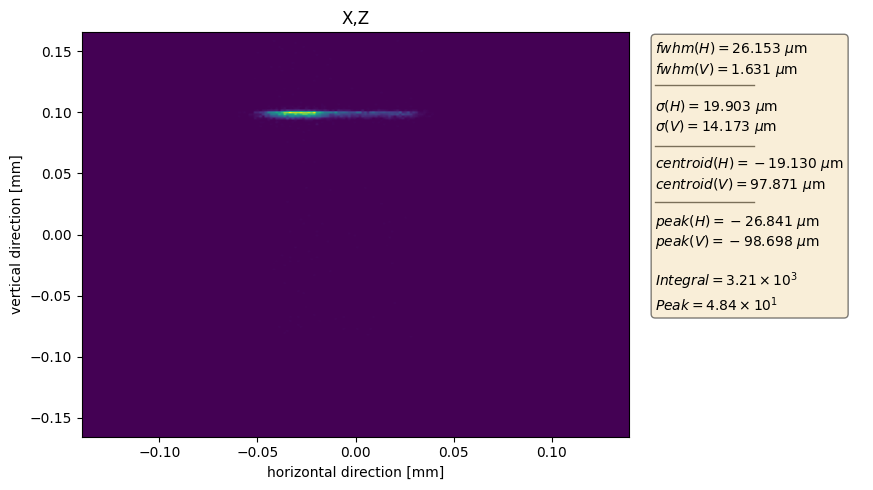

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3402590756520756, -3.381965609588921]


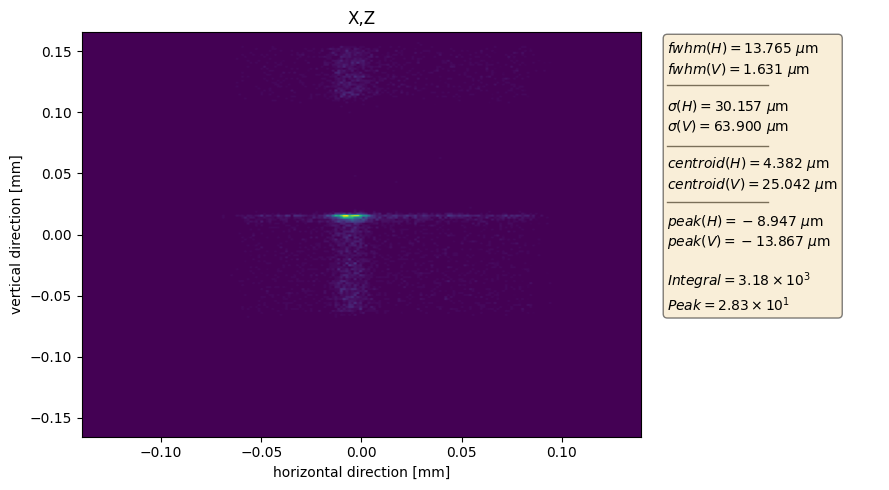

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415968966454093, -4.939639812741813]


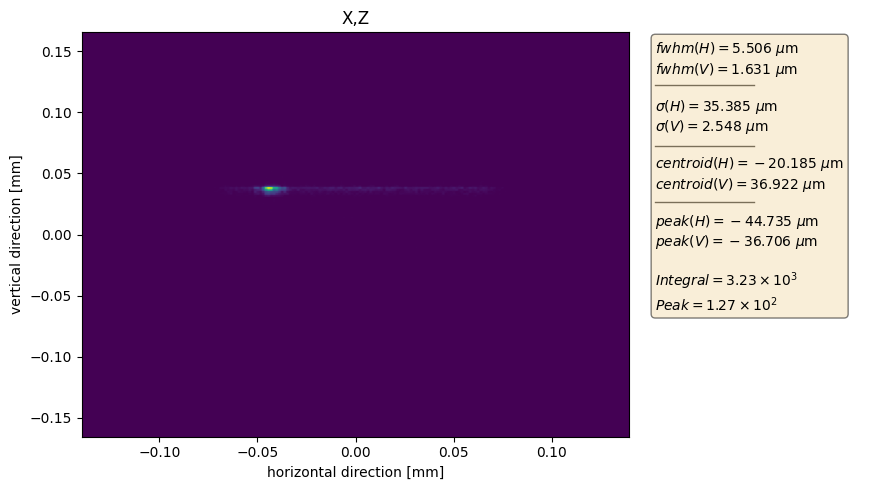

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415950075024405, -4.391330756685709]


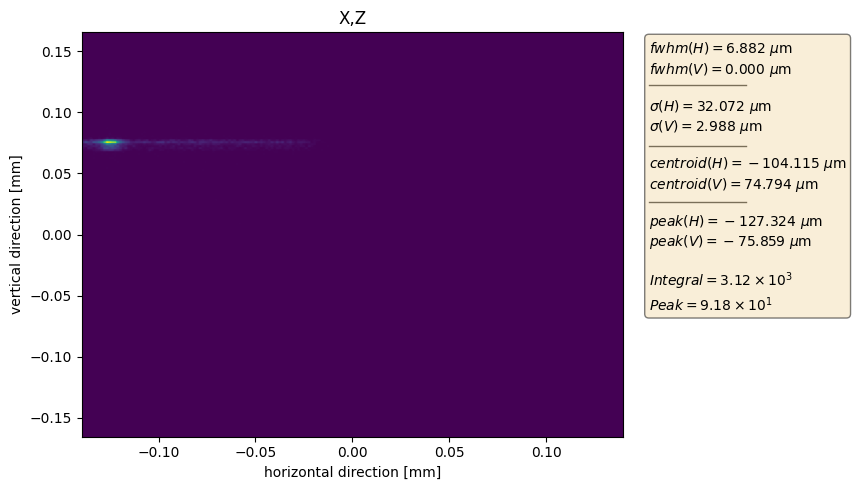

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415890920860931, -4.051377760930098]


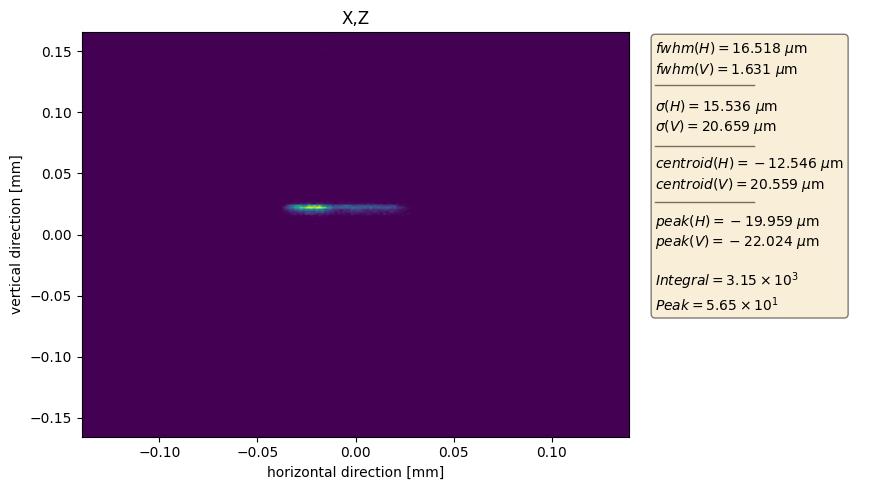

In [46]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415968966454093, -4.939639812741813]


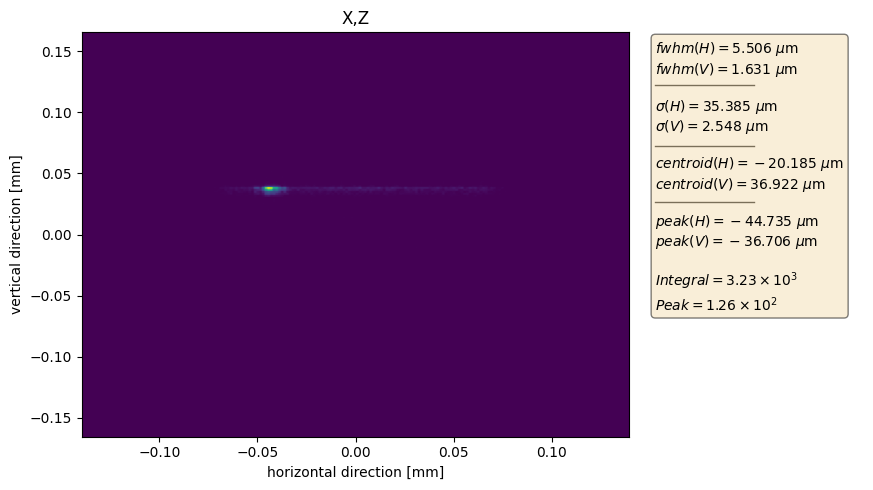

In [47]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

#### KL Divergence without removing noise, with larger fwhm

In [83]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/aps/common/plot/image.py:64: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/aps/common/plot/image.py:73: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)


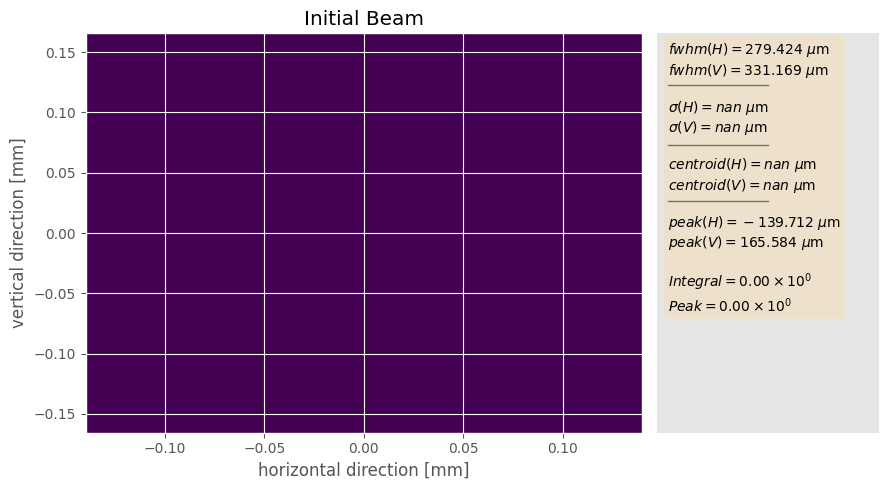

In [84]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [85]:
opt_params = OptimizationParameters()

In [86]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.342e+00
Perturbed beam system negative_log_peak_intensity: -3.828e+00


In [87]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (10e-3, 10e-3)},
)

In [88]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [89]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-22 16:04:45,433] A new study created in memory with name: no-name-aff62d70-3410-477f-a6ac-20a1b236a37c


In [90]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-22 16:06:28,591] Trial 0 finished with values: [1.3395890101205243, -3.8293014618316303] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:06:35,894] Trial 1 finished with values: [1.339548805245137, -2.2803609789379236] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:06:42,785] Trial 2 finished with values: [1.3395518381697582, -2.2667696475553893] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:06:49,797] Trial 3 finished with values: [1.3395642151946912, -2.0231185565870624] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:06:57,380] Trial 4 finished with values: [1.3395890074675172, -2.16632563094331] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:04,773] Trial 5 finished with values: [1.3395507027206475, -3.2619705174928404] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:12,814] Trial 6 finished with values: [1.3395809002997396, -3.624571056926039] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:19,590] Trial 7 finished with values: [1.339561810744743, -2.6722593148202343] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:26,859] Trial 8 finished with values: [1.3395760569591995, -3.0249498093030094] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:34,842] Trial 9 finished with values: [1.339564585668354, -2.748833353123273] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:44,897] Trial 10 finished with values: [1.3395439330321213, -2.759073846552167] and parameters: {'hb_1': -5.0, 'hb_2': -16.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.017800000000000003, 'vb_bender': 8.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.016800000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:54,707] Trial 11 finished with values: [1.3395856660642036, -3.3367486952570964] and parameters: {'hb_1': 1.0, 'hb_2': -14.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.007800000000000001, 'vb_bender': 1.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.003199999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:05,240] Trial 12 finished with values: [1.3395481639319033, -3.0498042008382313] and parameters: {'hb_1': -18.0, 'hb_2': -11.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.0097, 'vb_bender': 4.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': 0.029200000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:25,379] Trial 14 finished with values: [1.3395576327686218, -3.9213864341952904] and parameters: {'hb_1': -14.0, 'hb_2': -16.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.013700000000000004, 'vb_bender': -2.0, 'vb_pitch': -0.00084, 'vb_trans': 0.0245}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:36,486] Trial 15 finished with values: [1.3395675671357248, -2.488136419495011] and parameters: {'hb_1': -16.0, 'hb_2': -23.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0221, 'vb_bender': 10.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': 0.025100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:44,828] Trial 16 finished with values: [1.3395465705178389, -0.8551966959953073] and parameters: {'hb_1': -22.0, 'hb_2': 19.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.0233, 'vb_bender': 11.0, 'vb_pitch': -0.00152, 'vb_trans': 0.023400000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:55,556] Trial 17 finished with values: [1.3395639282743972, -3.287261826983174] and parameters: {'hb_1': -16.0, 'hb_2': -10.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.008300000000000002, 'vb_bender': -6.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': 0.024400000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spe

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:06,623] Trial 18 finished with values: [1.3395603669767102, -1.5441246871918215] and parameters: {'hb_1': -6.0, 'hb_2': -10.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.014000000000000005, 'vb_bender': -6.0, 'vb_pitch': -0.00156, 'vb_trans': 0.029300000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:16,778] Trial 19 finished with values: [1.3395307804460395, -3.238649519892368] and parameters: {'hb_1': -15.0, 'hb_2': -21.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.020500000000000004, 'vb_bender': -7.0, 'vb_pitch': -0.0005, 'vb_trans': 0.021900000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:26,831] Trial 20 finished with values: [1.3395516726386978, -2.6055039917282454] and parameters: {'hb_1': -2.0, 'hb_2': -11.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.015300000000000001, 'vb_bender': -9.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.017400000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:35,355] Trial 21 finished with values: [1.3395532441622553, -1.8003571107885807] and parameters: {'hb_1': -21.0, 'hb_2': -7.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.021900000000000003, 'vb_bender': -16.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.023100000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:43,862] Trial 22 finished with values: [1.339550450285911, -2.7021256945809755] and parameters: {'hb_1': -9.0, 'hb_2': -21.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.011000000000000003, 'vb_bender': -9.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.015300000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:54,026] Trial 23 finished with values: [1.3395627498495721, -2.974460150304768] and parameters: {'hb_1': 3.0, 'hb_2': -16.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.020800000000000006, 'vb_bender': 2.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': 0.024}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:04,392] Trial 24 finished with values: [1.3395812019155136, -4.071235824024622] and parameters: {'hb_1': -11.0, 'hb_2': -18.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.021700000000000004, 'vb_bender': 4.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': 0.020500000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:15,848] Trial 25 finished with values: [1.3395476132619681, -2.8094123420729153] and parameters: {'hb_1': -21.0, 'hb_2': -24.0, 'hb_pitch': 0.0015, 'hb_trans': 0.004900000000000002, 'vb_bender': 4.0, 'vb_pitch': -0.00108, 'vb_trans': 0.013700000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:26,706] Trial 26 finished with values: [1.339568608504591, -3.422505576234284] and parameters: {'hb_1': -17.0, 'hb_2': -16.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.017100000000000004, 'vb_bender': -1.0, 'vb_pitch': -0.00104, 'vb_trans': 0.014100000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:37,696] Trial 27 finished with values: [1.3395906126823616, -4.717717179424696] and parameters: {'hb_1': -11.0, 'hb_2': -8.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.005600000000000001, 'vb_bender': -2.0, 'vb_pitch': 0.00022000000000000014, 'vb_trans': 0.005500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:50,221] Trial 28 finished with values: [1.3395315159961734, -1.5183228768308672] and parameters: {'hb_1': -14.0, 'hb_2': -14.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.018400000000000007, 'vb_bender': -1.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': 0.015600000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spe

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:01,288] Trial 29 finished with values: [1.339548684454799, -1.8369606036706303] and parameters: {'hb_1': -25.0, 'hb_2': -21.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.0291, 'vb_bender': -16.0, 'vb_pitch': -0.00082, 'vb_trans': 0.021500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:13,237] Trial 30 finished with values: [1.3395653767023863, -3.0956436710831707] and parameters: {'hb_1': -10.0, 'hb_2': -22.0, 'hb_pitch': 0.0, 'hb_trans': 0.027200000000000002, 'vb_bender': 12.0, 'vb_pitch': -0.001, 'vb_trans': 0.015900000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:25,371] Trial 31 finished with values: [1.3395757438920317, -2.5094329786245377] and parameters: {'hb_1': -6.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.013600000000000001, 'vb_bender': 9.0, 'vb_pitch': 0.00031999999999999997, 'vb_trans': 0.0177}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:36,588] Trial 32 finished with values: [1.3395829123048897, -4.228812487459858] and parameters: {'hb_1': -12.0, 'hb_2': 4.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0002999999999999982, 'vb_bender': -4.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': 0.012700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:49,719] Trial 33 finished with values: [1.3395767673056593, -2.1426302406761084] and parameters: {'hb_1': -19.0, 'hb_2': -19.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.014700000000000005, 'vb_bender': -17.0, 'vb_pitch': -0.00098, 'vb_trans': 0.0172}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:01,893] Trial 34 finished with values: [1.3395881072690559, -4.392577698006566] and parameters: {'hb_1': -21.0, 'hb_2': 4.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.005299999999999999, 'vb_bender': -1.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.018800000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:13,721] Trial 35 finished with values: [1.3395717986501916, -3.80081663892099] and parameters: {'hb_1': -3.0, 'hb_2': 2.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': -0.005799999999999996, 'vb_bender': -5.0, 'vb_pitch': 0.00031999999999999997, 'vb_trans': 0.021700000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specif

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:25,129] Trial 36 finished with values: [1.3395720997669458, -4.249656857848784] and parameters: {'hb_1': -9.0, 'hb_2': -5.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0022999999999999965, 'vb_bender': 0.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.0199}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:37,276] Trial 37 finished with values: [1.3396146027359987, -4.287762404423473] and parameters: {'hb_1': -16.0, 'hb_2': 0.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.008599999999999997, 'vb_bender': -2.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0039000000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is sp

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:49,787] Trial 38 finished with values: [1.33954340339975, -3.672882081300439] and parameters: {'hb_1': -21.0, 'hb_2': 14.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.007899999999999997, 'vb_bender': 0.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.028200000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:01,571] Trial 39 finished with values: [1.3395846140092895, -4.140209479184962] and parameters: {'hb_1': -14.0, 'hb_2': 1.0, 'hb_pitch': -0.0015, 'hb_trans': -0.009799999999999996, 'vb_bender': -6.0, 'vb_pitch': 0.00034, 'vb_trans': 0.028200000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:12,361] Trial 40 finished with values: [1.3395437205979897, -3.5318662203241016] and parameters: {'hb_1': -18.0, 'hb_2': -19.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0168, 'vb_bender': -1.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.029700000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:23,711] Trial 41 finished with values: [1.3395898130401227, -3.699952592765388] and parameters: {'hb_1': -17.0, 'hb_2': -5.0, 'hb_pitch': 0.0005, 'hb_trans': -0.0036999999999999984, 'vb_bender': -2.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.029800000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:35,278] Trial 42 finished with values: [1.3395674868102054, -3.584620664660414] and parameters: {'hb_1': -4.0, 'hb_2': -23.0, 'hb_pitch': 0.0013, 'hb_trans': -0.002799999999999997, 'vb_bender': -3.0, 'vb_pitch': 0.0002800000000000003, 'vb_trans': -0.007499999999999996}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:47,987] Trial 43 finished with values: [1.339591356686324, -3.0031669096292317] and parameters: {'hb_1': -23.0, 'hb_2': -10.0, 'hb_pitch': 0.0, 'hb_trans': 0.015400000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.0008599999999999999, 'vb_trans': 0.029300000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:00,241] Trial 44 finished with values: [1.3395414679509128, -4.05288686236775] and parameters: {'hb_1': -13.0, 'hb_2': -19.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.0019999999999999983, 'vb_bender': 1.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': 0.014600000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:14,442] Trial 45 finished with values: [1.3395882398088643, -4.373781639718862] and parameters: {'hb_1': -13.0, 'hb_2': -16.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.00030000000000000165, 'vb_bender': -1.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0126}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:26,350] Trial 46 finished with values: [1.339551821570129, -3.5497870345944196] and parameters: {'hb_1': -7.0, 'hb_2': -24.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.0223, 'vb_bender': -4.0, 'vb_pitch': -0.00066, 'vb_trans': 0.025500000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:39,871] Trial 47 finished with values: [1.3395530768931023, -4.022796670923751] and parameters: {'hb_1': -12.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.007099999999999999, 'vb_bender': 1.0, 'vb_pitch': -0.00017999999999999982, 'vb_trans': 0.0013000000000000025}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is sp

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:51,736] Trial 48 finished with values: [1.3395604434279782, -3.1541192018271262] and parameters: {'hb_1': -18.0, 'hb_2': -15.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.011799999999999998, 'vb_bender': 4.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': -0.001299999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:15:07,074] Trial 49 finished with values: [1.3395762581217363, -3.2485329259017104] and parameters: {'hb_1': 1.0, 'hb_2': -25.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0036999999999999984, 'vb_bender': -4.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': 0.0119}. 


/tmp/ipykernel_758275/2987871832.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


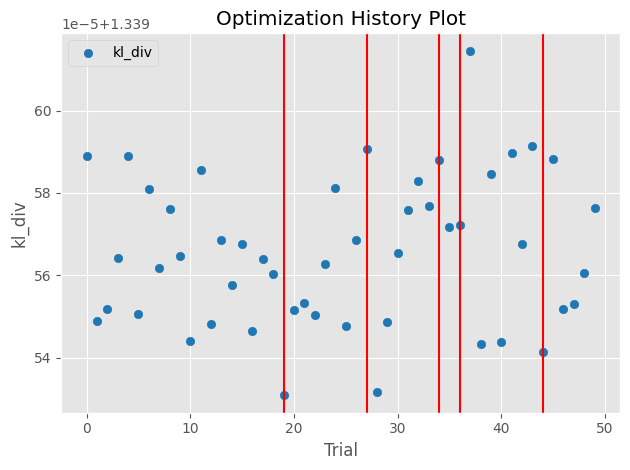

In [91]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[0], target_name="kl_div"
)
for t in opt_trial.study.best_trials:
    plt.axvline(t.number, color="red")
# plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/tmp/ipykernel_758275/740841843.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


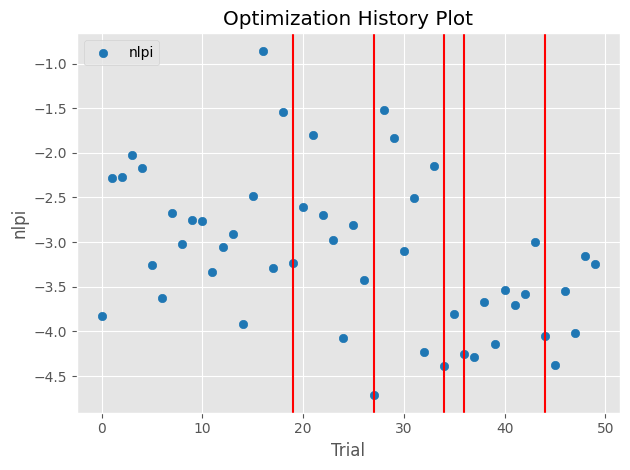

In [92]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[1], target_name="nlpi"
)
for t in opt_trial.study.best_trials:
    plt.axvline(t.number, color="red")
# plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [93]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

nan 207251.86732941077
nan 207573.94831842338
nan 207576.5801028653
nan 207120.25781019492
nan 207364.53470298945


/tmp/ipykernel_758275/261318559.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs["ws"])


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395307804460395, -3.238649519892368]


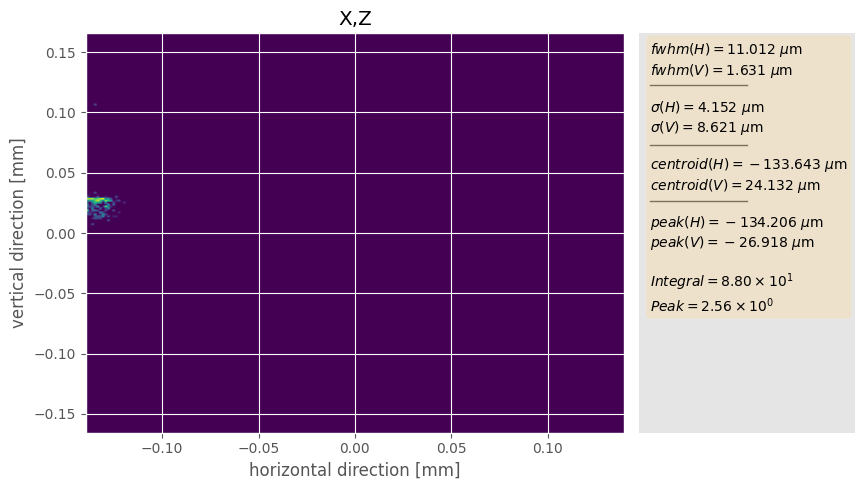

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395906126823616, -4.717717179424696]


/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/aps/common/plot/image.py:64: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/aps/common/plot/image.py:73: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)


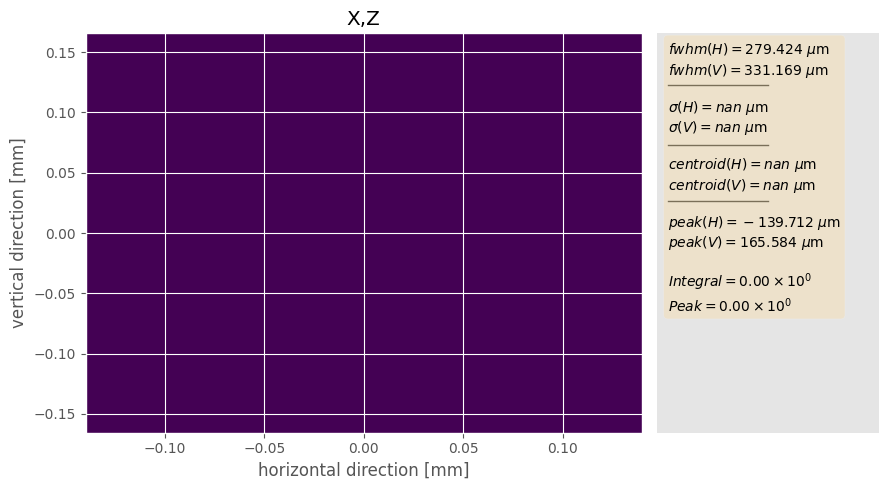

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395881072690559, -4.392577698006566]


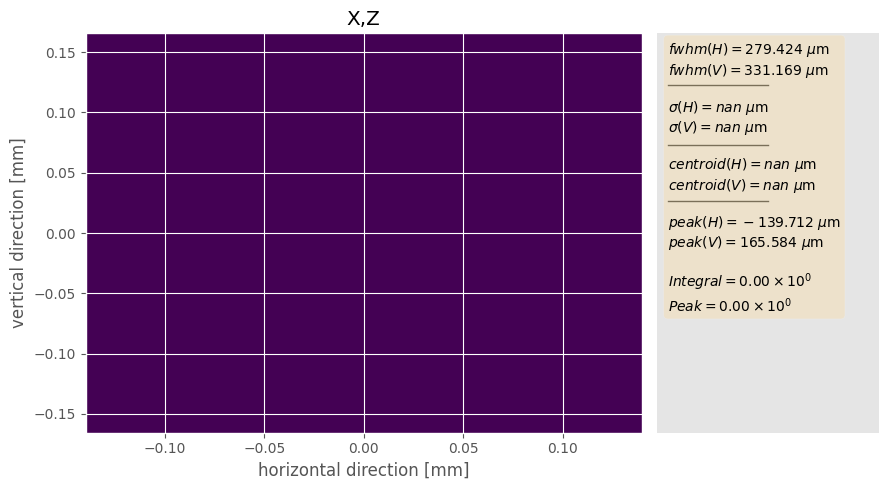

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395720997669458, -4.249656857848784]


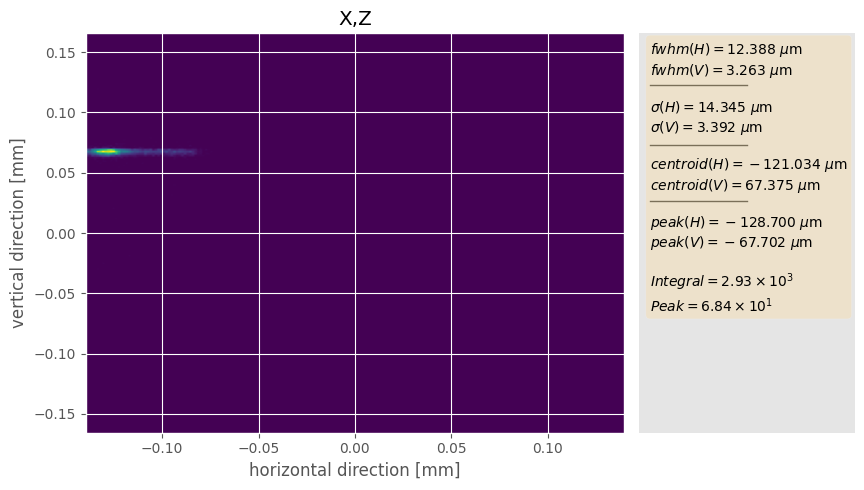

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395414679509128, -4.05288686236775]


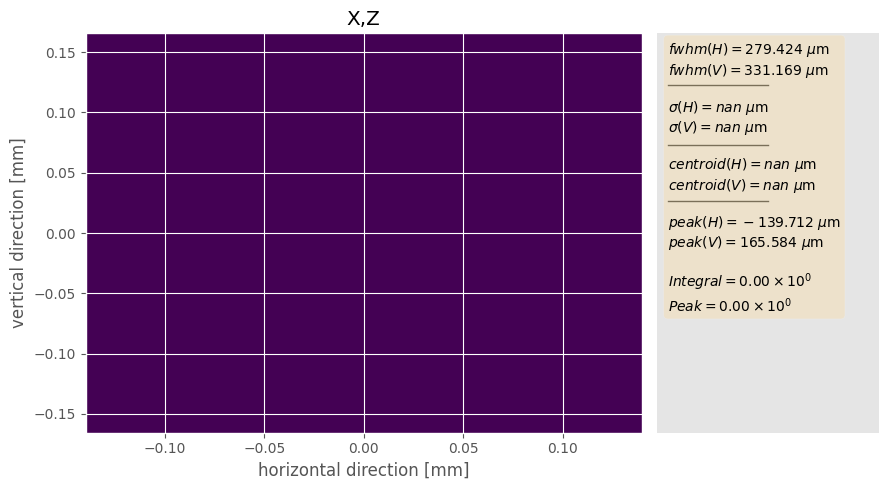

In [94]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[1.3395414679509128, -4.05288686236775]


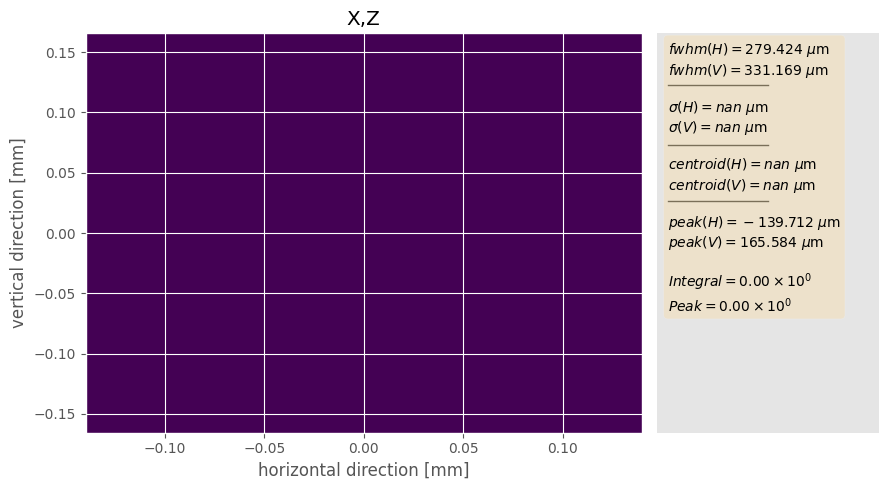

In [95]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

/tmp/ipykernel_758275/2059645299.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(


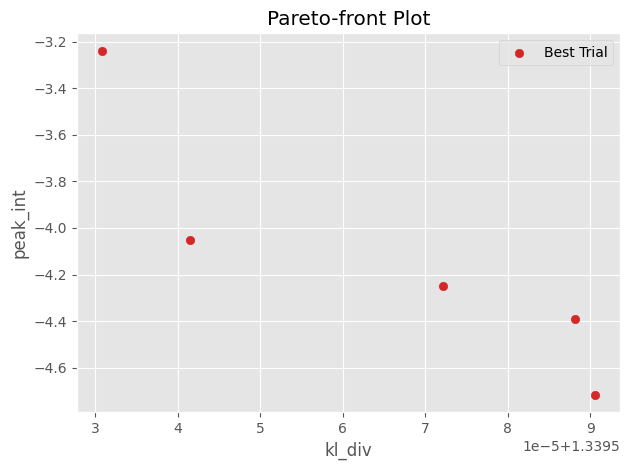

In [98]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(
    opt_trial.study, target_names=["kl_div", "peak_int"], include_dominated_trials=False
)
# plt.scatter(*nash_trial.values, color='orange', label='Nash')
plt.legend(loc="best")
plt.tight_layout()

# plt.savefig(...) to save the image
plt.show()

#### KL Divergence after removing noise

In [19]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

In [20]:
cp = dt.replace(cp, calculate_over_noise=True)

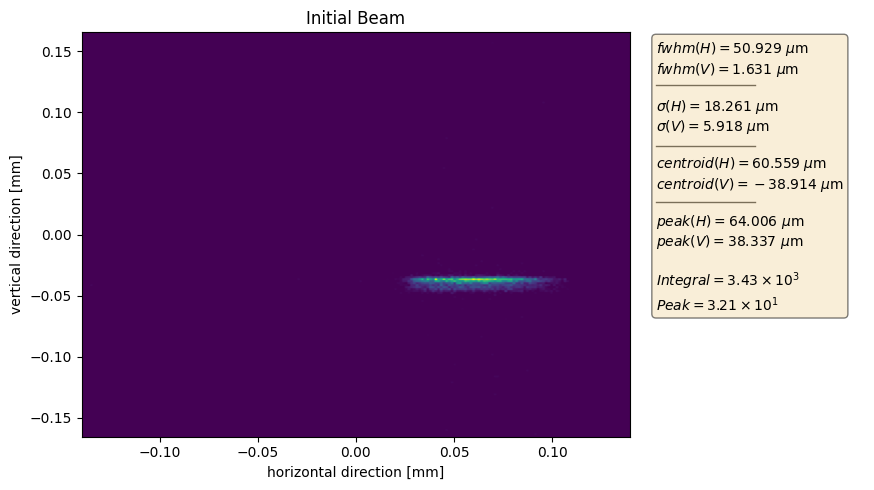

In [21]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [22]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.386e+00
Perturbed beam system negative_log_peak_intensity: -3.469e+00
Perturbed beam system peak_distance: 5.452e-02


In [23]:
opt_params = OptimizationParameters()

In [24]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (5e-3, 5e-3)},
)

In [25]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [26]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-22 22:38:25,878] A new study created in memory with name: no-name-cef1ab80-66e4-4ff4-9bd4-cd9982e551a7


In [27]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-22 22:38:33,435] Trial 0 finished with values: [1.3862145627192466, -3.4690132234613356, 0.05452336841015334] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:38:40,534] Trial 1 finished with values: [1.386175006591286, -3.1119758563827773, 0.09908490605198311] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:38:48,078] Trial 2 finished with values: [1.3861805793801032, -3.1224515913818145, 0.14328160059562559] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:38:55,419] Trial 3 finished with values: [1.3861238245766045, -3.1365768705112815, 0.09159099521353244] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:39:02,543] Trial 4 finished with values: [1.3859966517016225, -1.7508355681506933, 0.15612642458287918] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:39:09,792] Trial 5 finished with values: [1.3861169567319447, -3.0196250177524204, 0.10794457746052419] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:39:17,195] Trial 6 finished with values: [1.3860742546911957, -2.1778382436710064, 0.07184296524661293] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:39:24,479] Trial 7 finished with values: [1.3860393117621552, -3.007995917710252, 0.16685419226373271] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:39:31,960] Trial 8 finished with values: [1.385793006360625, -1.051495081758581, 0.4613535287553632] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:39:39,159] Trial 9 finished with values: [1.3861704298094024, -2.816385747070054, 0.2752893306132096] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but th

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:39:58,381] Trial 10 finished with values: [1.3857799761925347, -1.0890945457384857, 0.05848836698368498] and parameters: {'hb_1': 22.0, 'hb_2': -17.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.026900000000000007, 'vb_bender': 19.0, 'vb_pitch': -0.00106, 'vb_trans': 0.0233}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and ste

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:40:15,765] Trial 11 finished with values: [1.3848282002634549, -4.154910316892676, 0.03255407869535507] and parameters: {'hb_1': -25.0, 'hb_2': -9.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.024399999999999998, 'vb_bender': -5.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.005600000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:40:31,952] Trial 12 finished with values: [1.3248585759703917, -2.5144595150150275, 0.0429804487359225] and parameters: {'hb_1': -5.0, 'hb_2': 5.0, 'hb_pitch': 0.0005, 'hb_trans': -0.014799999999999999, 'vb_bender': -20.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.021500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:40:49,731] Trial 13 finished with values: [1.3861306033846452, -2.5538006294018114, 0.16283525673242125] and parameters: {'hb_1': 3.0, 'hb_2': -25.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.0032999999999999974, 'vb_bender': -14.0, 'vb_pitch': 0.00168, 'vb_trans': 0.005500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:41:07,275] Trial 14 finished with values: [1.385765614527837, -1.0562226489536557, 0.31557046022459634] and parameters: {'hb_1': 4.0, 'hb_2': 7.0, 'hb_pitch': -0.0016, 'hb_trans': 0.025800000000000003, 'vb_bender': 16.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': 0.004300000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:41:24,894] Trial 15 finished with values: [1.386077091408517, -1.9616457089732589, 0.09417308878871955] and parameters: {'hb_1': 0.0, 'hb_2': -6.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.028900000000000002, 'vb_bender': 14.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': 0.008400000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:41:42,951] Trial 16 finished with values: [1.3861425423995895, -2.611824696964066, 0.14410854700275197] and parameters: {'hb_1': -22.0, 'hb_2': -1.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.012799999999999999, 'vb_bender': -13.0, 'vb_pitch': 0.00068, 'vb_trans': -0.009799999999999996}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:42:01,618] Trial 17 finished with values: [1.3593799264601578, -1.8784818443369364, 0.05555139752955428] and parameters: {'hb_1': 22.0, 'hb_2': 10.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0267, 'vb_bender': 15.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.009100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:42:18,218] Trial 18 finished with values: [1.3861778413990926, -3.4946561663208233, 0.028445762088012732] and parameters: {'hb_1': -7.0, 'hb_2': -17.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.026500000000000003, 'vb_bender': -10.0, 'vb_pitch': -0.0012799999999999999, 'vb_trans': 0.015300000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:42:26,772] Trial 19 finished with values: [1.3780074764238002, -1.6341817458097048, 0.08068126294461521] and parameters: {'hb_1': 19.0, 'hb_2': 24.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.023700000000000006, 'vb_bender': -18.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': -0.0121}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:42:45,539] Trial 20 finished with values: [1.3861691983719564, -2.879779925700325, 0.17897384734876923] and parameters: {'hb_1': -22.0, 'hb_2': 3.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': 0.0006000000000000033, 'vb_bender': -9.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.0030000000000000027}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:43:05,167] Trial 21 finished with values: [1.3858417325090617, -1.339064289771824, 0.10588737249761876] and parameters: {'hb_1': -1.0, 'hb_2': 6.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': -0.028999999999999998, 'vb_bender': -16.0, 'vb_pitch': -0.00098, 'vb_trans': 0.021300000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:43:24,379] Trial 22 finished with values: [1.3785836468588606, -2.9694501459699496, 0.09570922925765304] and parameters: {'hb_1': 25.0, 'hb_2': -17.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.023399999999999997, 'vb_bender': -9.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.020700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:43:44,798] Trial 23 finished with values: [1.3858377212804456, -1.9472921106050725, 0.16019669707675932] and parameters: {'hb_1': -6.0, 'hb_2': -18.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026600000000000006, 'vb_bender': 10.0, 'vb_pitch': -0.002, 'vb_trans': -0.016599999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:44:03,871] Trial 24 finished with values: [1.3861816297348932, -3.010410960823686, 0.07630795299533423] and parameters: {'hb_1': -11.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.011199999999999998, 'vb_bender': -11.0, 'vb_pitch': -0.00152, 'vb_trans': 0.0187}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:44:22,958] Trial 25 finished with values: [1.3861764756657182, -2.9639957331202234, 0.11087841738280135] and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': -0.0005, 'hb_trans': 0.0039000000000000007, 'vb_bender': -17.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.016399999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:44:41,615] Trial 26 finished with values: [1.386105602658392, -2.537026689291745, 0.10156727649900842] and parameters: {'hb_1': -12.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.016600000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0018000000000000004, 'vb_trans': -0.0208}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:45:00,610] Trial 27 finished with values: [1.3857961190992225, -1.866475663191742, 0.12359576497708079] and parameters: {'hb_1': 22.0, 'hb_2': -4.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0286, 'vb_bender': 20.0, 'vb_pitch': 8.000000000000021e-05, 'vb_trans': -0.0278}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but th

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:45:19,904] Trial 28 finished with values: [1.385990661738649, -1.563846880604424, 0.24876084758933728] and parameters: {'hb_1': -23.0, 'hb_2': 6.0, 'hb_pitch': -0.0015, 'hb_trans': -0.0215, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.015100000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:45:39,449] Trial 29 finished with values: [1.3861243896036044, -2.3892621468249478, 0.23514398185690774] and parameters: {'hb_1': 10.0, 'hb_2': 2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.009499999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0236}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:45:59,557] Trial 30 finished with values: [1.385949109028675, -3.2193698793059666, 0.027685807566012553] and parameters: {'hb_1': -17.0, 'hb_2': 13.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.003199999999999998, 'vb_bender': -2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.009599999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:46:19,626] Trial 31 finished with values: [1.3708438399634133, -2.1532715626733334, 0.11407845058167418] and parameters: {'hb_1': -5.0, 'hb_2': 19.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.009399999999999999, 'vb_bender': 20.0, 'vb_pitch': -0.0019, 'vb_trans': 0.020700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:46:40,479] Trial 32 finished with values: [1.3861754419571644, -2.9814338458929504, 0.07525106620666902] and parameters: {'hb_1': -17.0, 'hb_2': -18.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0279, 'vb_bender': -9.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0224}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:46:59,950] Trial 33 finished with values: [1.386148763152108, -2.542721473920861, 0.2364877210417525] and parameters: {'hb_1': -14.0, 'hb_2': -2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.009400000000000006, 'vb_bender': -15.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.010899999999999996}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:47:20,206] Trial 34 finished with values: [1.386133953250924, -3.4023728110278775, 0.1957606072895248] and parameters: {'hb_1': -5.0, 'hb_2': 11.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0291, 'vb_bender': -9.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.029400000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:47:40,141] Trial 35 finished with values: [1.3601178128462157, -2.9734747139631184, 0.011528154655536266] and parameters: {'hb_1': -23.0, 'hb_2': 17.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.026000000000000002, 'vb_bender': -5.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.0077000000000000055}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.00

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:47:59,965] Trial 36 finished with values: [1.386226142243435, -3.8335745426889813, 0.2565955520806328] and parameters: {'hb_1': -4.0, 'hb_2': -21.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': -1.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': -0.0247}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:48:21,441] Trial 37 finished with values: [1.3860361206394443, -2.0287417917902157, 0.057555753032897054] and parameters: {'hb_1': -23.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.023200000000000005, 'vb_bender': 18.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': 0.0172}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:48:42,551] Trial 38 finished with values: [1.3861778310540736, -2.7392983595066775, 0.1468573754307706] and parameters: {'hb_1': -9.0, 'hb_2': -8.0, 'hb_pitch': -0.0005, 'hb_trans': -0.013699999999999997, 'vb_bender': 13.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': -0.014599999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:49:03,512] Trial 39 finished with values: [1.386093041414077, -2.2350953231365143, 0.10080486477284382] and parameters: {'hb_1': -18.0, 'hb_2': -5.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026800000000000004, 'vb_bender': -16.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0235}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and ste

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:49:24,628] Trial 40 finished with values: [1.386219904959837, -3.957362480461228, 0.08634186844875956] and parameters: {'hb_1': -8.0, 'hb_2': -16.0, 'hb_pitch': 0.0015, 'hb_trans': -0.009399999999999999, 'vb_bender': 4.0, 'vb_pitch': -0.00156, 'vb_trans': 0.012100000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:49:46,839] Trial 41 finished with values: [1.3859529486404691, -1.546698942020716, 0.30990436098169843] and parameters: {'hb_1': 16.0, 'hb_2': 25.0, 'hb_pitch': -0.0019, 'hb_trans': -0.014299999999999997, 'vb_bender': 11.0, 'vb_pitch': 0.00046000000000000034, 'vb_trans': -0.0163}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and ste

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:50:07,689] Trial 42 finished with values: [1.3861590989137889, -3.016191437376113, 0.20364794658634355] and parameters: {'hb_1': 11.0, 'hb_2': 14.0, 'hb_pitch': -0.0014, 'hb_trans': 0.019600000000000006, 'vb_bender': -7.0, 'vb_pitch': 0.0007800000000000003, 'vb_trans': -0.015199999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:50:28,716] Trial 43 finished with values: [1.3857930403937369, -1.5547707860871942, 0.060197316574412255] and parameters: {'hb_1': -21.0, 'hb_2': 20.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.025300000000000003, 'vb_bender': -15.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': -0.000499999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.00

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:50:49,572] Trial 44 finished with values: [1.3858359547899866, -1.4168194352314645, 0.2394227331552286] and parameters: {'hb_1': 6.0, 'hb_2': 1.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': 10.0, 'vb_pitch': -0.00192, 'vb_trans': -0.0254}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and ste

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:51:13,318] Trial 45 finished with values: [1.3860081577649057, -1.9891755201849428, 0.15707034039310952] and parameters: {'hb_1': -1.0, 'hb_2': 20.0, 'hb_pitch': 0.0018, 'hb_trans': 0.0033000000000000043, 'vb_bender': -19.0, 'vb_pitch': -0.0018, 'vb_trans': 0.027200000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:51:38,578] Trial 46 finished with values: [1.386090489399536, -2.3436325219582472, 0.08069590021754615] and parameters: {'hb_1': 8.0, 'hb_2': -15.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.003199999999999998, 'vb_bender': 14.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': 0.0092}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:51:59,502] Trial 47 finished with values: [1.38606392506693, -3.490442451086598, 0.1822588247771201] and parameters: {'hb_1': -10.0, 'hb_2': 21.0, 'hb_pitch': -0.0009, 'hb_trans': -0.005199999999999996, 'vb_bender': -10.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': -0.010099999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:52:21,533] Trial 48 finished with values: [1.3861451600318146, -2.6772802388785917, 0.10456356632215669] and parameters: {'hb_1': -18.0, 'hb_2': 4.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0208, 'vb_bender': 3.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.0262}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_75764/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 22:52:45,856] Trial 49 finished with values: [1.3860587126007908, -2.881974360277543, 0.20197485082644212] and parameters: {'hb_1': -11.0, 'hb_2': 15.0, 'hb_pitch': -0.0009, 'hb_trans': -0.021599999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0005, 'vb_trans': 0.008}. 


/tmp/ipykernel_758275/2987871832.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


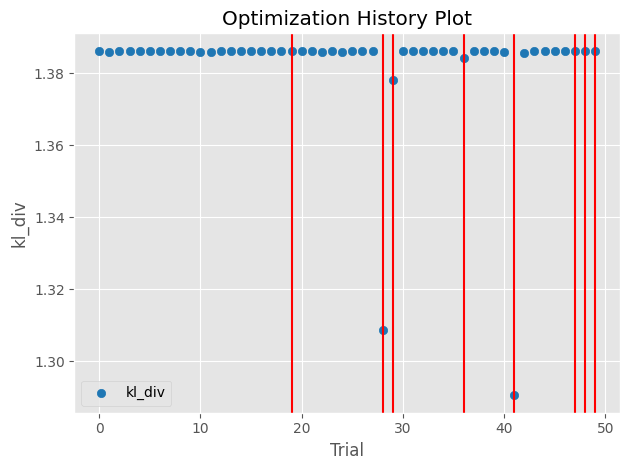

In [114]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[0], target_name="kl_div"
)
for t in opt_trial.study.best_trials:
    plt.axvline(t.number, color="red")
# plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/tmp/ipykernel_758275/740841843.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


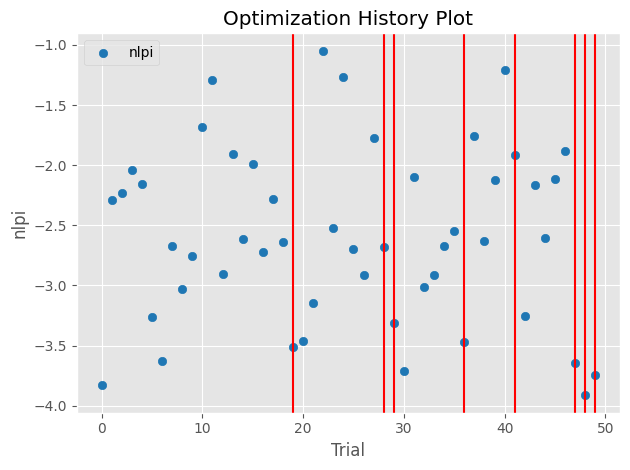

In [115]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[1], target_name="nlpi"
)
for t in opt_trial.study.best_trials:
    plt.axvline(t.number, color="red")
# plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [111]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

nan 101.46128459783534
nan 3.191452152402137
nan 3.405359888748676
nan 5.348204146392182
nan 8.788086649518084
nan 30.43183616327027
nan 376.3963441992433
nan 22.454841194603237


/tmp/ipykernel_758275/261318559.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs["ws"])


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3861381614775463, -3.5153534117099143]


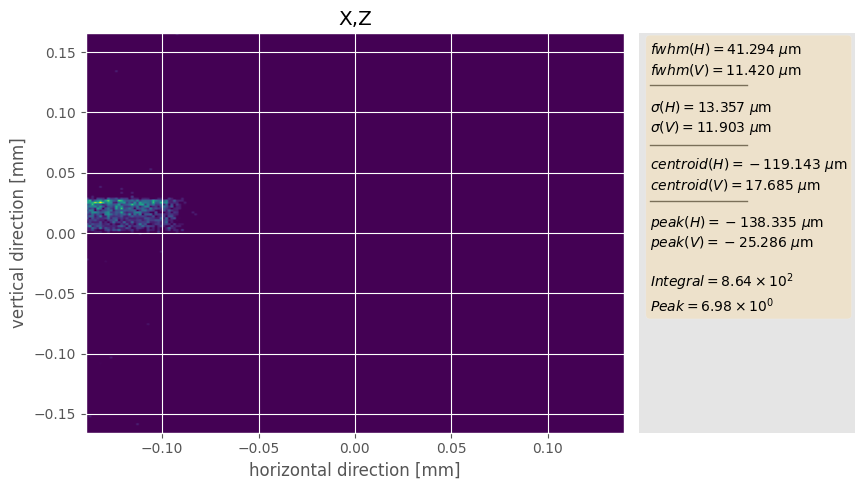

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3086621524298627, -2.6774856972839767]


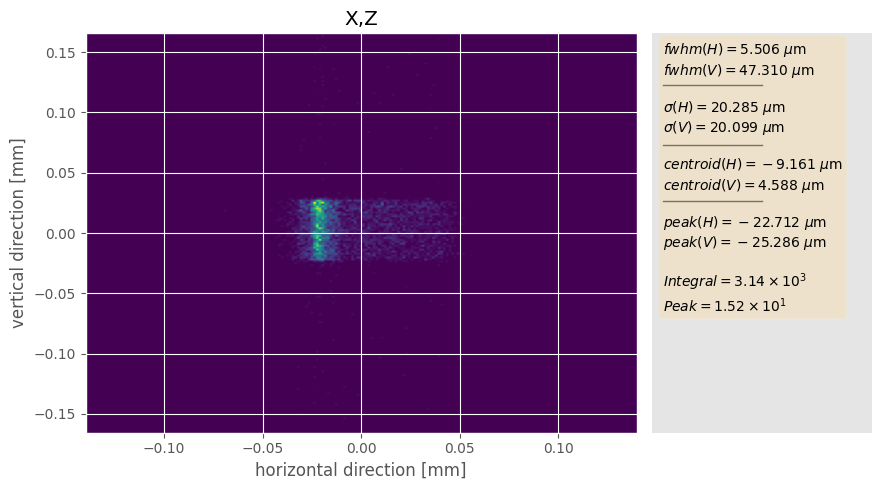

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.378205521726806, -3.311857032982369]


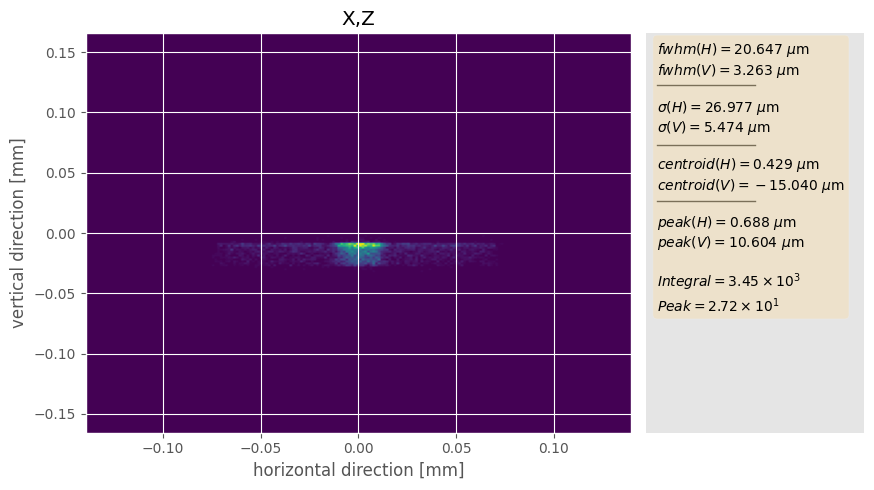

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3841039914846185, -3.4669312940312436]


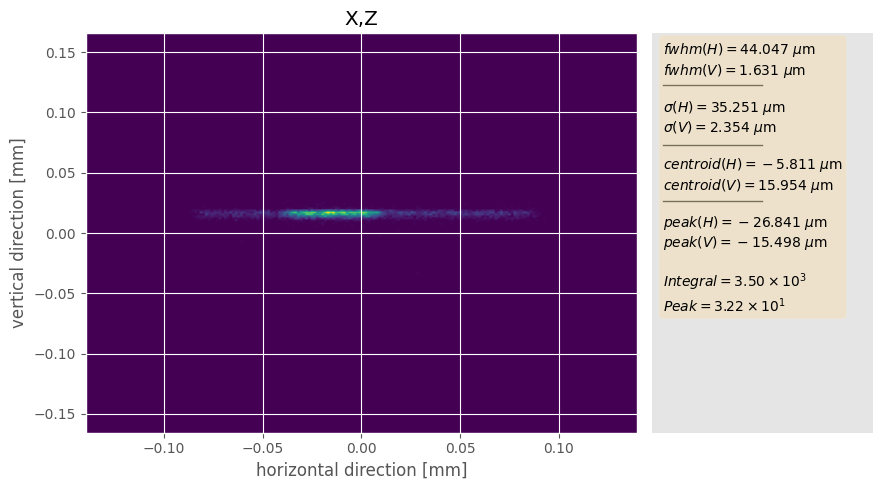

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.2904952407386134, -1.916964693433257]


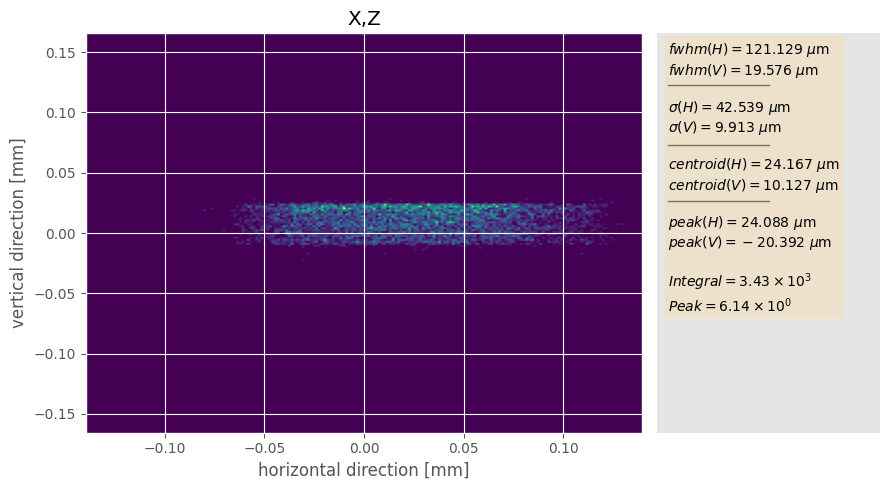

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3861600498924371, -3.648528808583591]


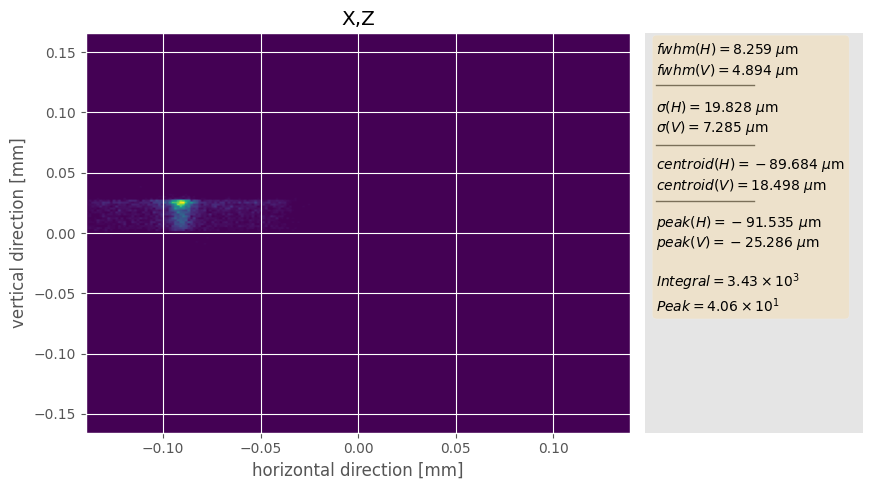

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3862211434151777, -3.9155575306624115]


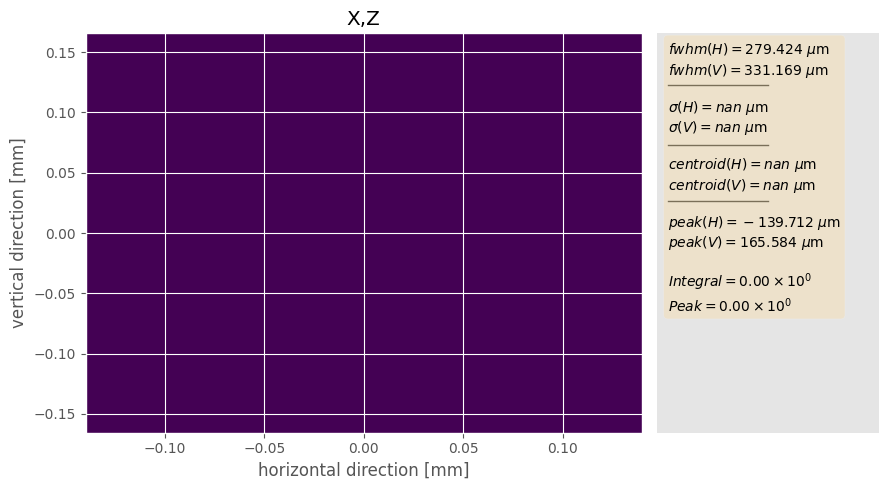

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.386178161305343, -3.745820294534648]


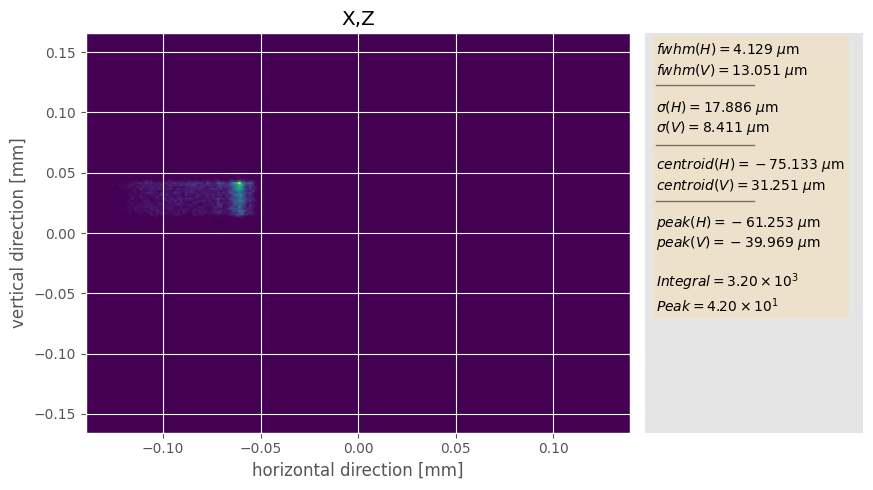

In [112]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3841039914846185, -3.4669312940312436]


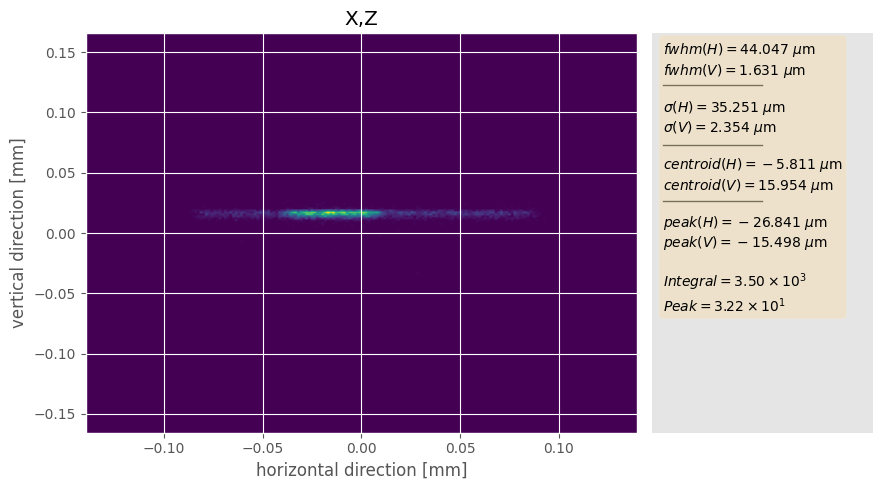

In [113]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

/tmp/ipykernel_3879159/1243347140.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

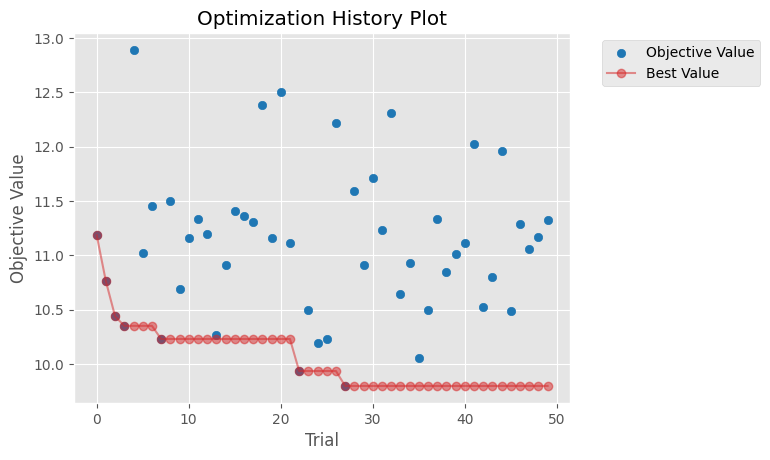

In [86]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)

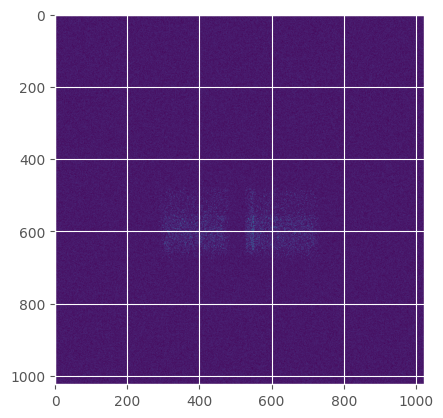

In [87]:
plt.imshow(opt_trial.beam_state.hist.data_2D)

#### KL Divergence removing noise, with larger fwhm

In [88]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

In [89]:
cp

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=True, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


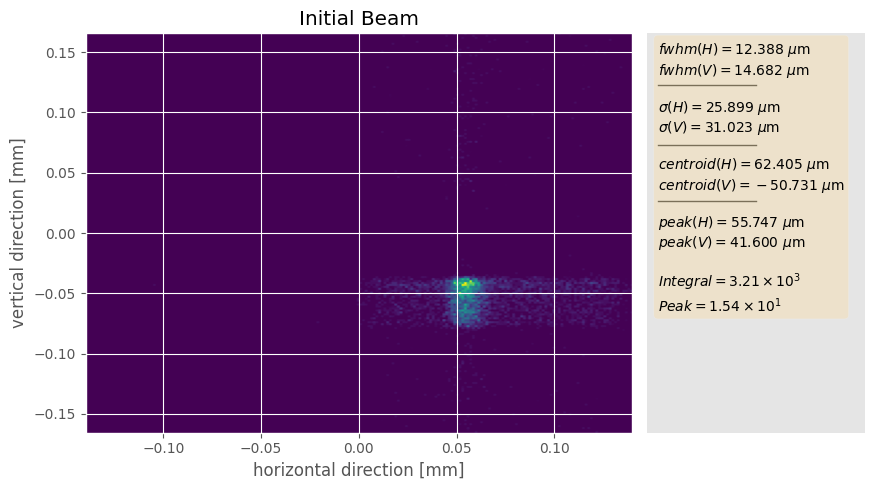

In [90]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [91]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.118e+01


In [92]:
opt_params = OptimizationParameters()

opt_params.params["loss_parameters"] = ["kl_divergence"]
opt_params.params["multi_objective_optimization"] = False

In [93]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (10e-3, 10e-3)},
)

In [94]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [95]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 21:01:34,380] A new study created in memory with name: no-name-283fd4f6-100a-4437-9a25-07504f4dd245


In [96]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-12 21:01:43,305] Trial 0 finished with value: 11.172432069603357 and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. Best is trial 0 with value: 11.172432069603357.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:01:51,031] Trial 1 finished with value: 10.763511264515474 and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. Best is trial 1 with value: 10.763511264515474.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:00,032] Trial 2 finished with value: 10.402497831881835 and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. Best is trial 2 with value: 10.402497831881835.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:08,053] Trial 3 finished with value: 10.352173643777103 and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. Best is trial 3 with value: 10.352173643777103.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:16,662] Trial 4 finished with value: 12.88776637832479 and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. Best is trial 3 with value: 10.352173643777103.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:24,538] Trial 5 finished with value: 11.023000997104004 and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. Best is trial 3 with value: 10.352173643777103.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:33,077] Trial 6 finished with value: 11.074992430807308 and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. Best is trial 3 with value: 10.352173643777103.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:41,331] Trial 7 finished with value: 10.238559417538669 and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. Best is trial 7 with value: 10.238559417538669.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:50,098] Trial 8 finished with value: 11.494307639645692 and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. Best is trial 7 with value: 10.238559417538669.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:58,196] Trial 9 finished with value: 10.697354556410462 and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. Best is trial 7 with value: 10.238559417538669.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, bu

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:13,047] Trial 10 finished with value: 11.167825551872948 and parameters: {'hb_1': 21.0, 'hb_2': 18.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.022700000000000005, 'vb_bender': -4.0, 'vb_pitch': 0.0007000000000000001, 'vb_trans': 0.004700000000000003}. Best is trial 7 with value: 10.238559417538669.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:27,698] Trial 11 finished with value: 11.322111150242542 and parameters: {'hb_1': -16.0, 'hb_2': -7.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.0010000000000000009, 'vb_bender': 8.0, 'vb_pitch': 0.0004400000000000003, 'vb_trans': 0.020500000000000004}. Best is trial 7 with value: 10.238559417538669.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:41,042] Trial 12 finished with value: 11.199896322867893 and parameters: {'hb_1': 1.0, 'hb_2': -10.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.020200000000000003, 'vb_bender': 4.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.007399999999999997}. Best is trial 7 with value: 10.238559417538669.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:55,001] Trial 13 finished with value: 10.070434209081002 and parameters: {'hb_1': -10.0, 'hb_2': -19.0, 'hb_pitch': 0.001, 'hb_trans': -0.0121, 'vb_bender': -15.0, 'vb_pitch': 0.0002800000000000003, 'vb_trans': 0.0257}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, b

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:09,100] Trial 14 finished with value: 10.682966186582995 and parameters: {'hb_1': -20.0, 'hb_2': -6.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0092, 'vb_bender': 3.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0011999999999999962}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:23,573] Trial 15 finished with value: 11.403547148498598 and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.018000000000000002, 'vb_bender': 17.0, 'vb_pitch': 0.0012000000000000001, 'vb_trans': -0.0196}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:40,964] Trial 16 finished with value: 11.359497289427066 and parameters: {'hb_1': 11.0, 'hb_2': 4.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.0158, 'vb_bender': -9.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.023299999999999998}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:55,812] Trial 17 finished with value: 11.307409882808788 and parameters: {'hb_1': 6.0, 'hb_2': -4.0, 'hb_pitch': 0.0013, 'hb_trans': 3.469446951953614e-18, 'vb_bender': -2.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': -0.011199999999999998}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:11,814] Trial 18 finished with value: 12.386854103539742 and parameters: {'hb_1': 16.0, 'hb_2': 23.0, 'hb_pitch': 0.0018, 'hb_trans': 0.013500000000000005, 'vb_bender': 16.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.002799999999999997}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:26,574] Trial 19 finished with value: 11.151100391329244 and parameters: {'hb_1': -15.0, 'hb_2': -13.0, 'hb_pitch': -0.0014, 'hb_trans': 0.00030000000000000165, 'vb_bender': 9.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.009599999999999997}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:41,216] Trial 20 finished with value: 12.507664464429126 and parameters: {'hb_1': -21.0, 'hb_2': 3.0, 'hb_pitch': 0.0018, 'hb_trans': -0.022699999999999998, 'vb_bender': 13.0, 'vb_pitch': -0.00118, 'vb_trans': 0.024200000000000006}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:56,607] Trial 21 finished with value: 10.775925213980665 and parameters: {'hb_1': -19.0, 'hb_2': 21.0, 'hb_pitch': 0.0015, 'hb_trans': 0.011500000000000003, 'vb_bender': 20.0, 'vb_pitch': -0.00198, 'vb_trans': 0.012200000000000003}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:11,005] Trial 22 finished with value: 9.939284102967813 and parameters: {'hb_1': 20.0, 'hb_2': -9.0, 'hb_pitch': -0.0015, 'hb_trans': 0.019000000000000003, 'vb_bender': 19.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': -0.010899999999999996}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:27,112] Trial 23 finished with value: 10.498361004506656 and parameters: {'hb_1': 1.0, 'hb_2': 18.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.003799999999999998, 'vb_bender': -13.0, 'vb_pitch': -0.0005, 'vb_trans': -0.0076999999999999985}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:42,500] Trial 24 finished with value: 10.054125483451953 and parameters: {'hb_1': -23.0, 'hb_2': -13.0, 'hb_pitch': 0.0015, 'hb_trans': 0.0075, 'vb_bender': -15.0, 'vb_pitch': 0.00082, 'vb_trans': 0.002800000000000004}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, bu

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:57,785] Trial 25 finished with value: 10.212405606650394 and parameters: {'hb_1': -21.0, 'hb_2': -16.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.021700000000000004, 'vb_bender': -18.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.0272}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:13,320] Trial 26 finished with value: 12.215085131069003 and parameters: {'hb_1': 18.0, 'hb_2': 21.0, 'hb_pitch': -0.001, 'hb_trans': 0.012100000000000007, 'vb_bender': 17.0, 'vb_pitch': 0.0017800000000000003, 'vb_trans': 0.021700000000000004}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:27,742] Trial 27 finished with value: 9.80157121430759 and parameters: {'hb_1': -21.0, 'hb_2': 22.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.028500000000000004, 'vb_bender': 0.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.0023999999999999994}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:43,066] Trial 28 finished with value: 11.592156170312942 and parameters: {'hb_1': 9.0, 'hb_2': 5.0, 'hb_pitch': -0.0018, 'hb_trans': -0.011799999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': -0.015099999999999999}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:58,068] Trial 29 finished with value: 10.917117024445567 and parameters: {'hb_1': -2.0, 'hb_2': 20.0, 'hb_pitch': -0.0005, 'hb_trans': -0.015899999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': 0.013500000000000005}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:12,692] Trial 30 finished with value: 11.712240769887805 and parameters: {'hb_1': 4.0, 'hb_2': 5.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.0028999999999999963, 'vb_bender': 4.0, 'vb_pitch': -0.00174, 'vb_trans': 0.010700000000000001}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:27,874] Trial 31 finished with value: 11.222460247218118 and parameters: {'hb_1': -18.0, 'hb_2': -22.0, 'hb_pitch': -0.0013, 'hb_trans': 0.025300000000000003, 'vb_bender': 10.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': 3.469446951953614e-18}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:43,905] Trial 32 finished with value: 12.3113145737943 and parameters: {'hb_1': 20.0, 'hb_2': -25.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.012199999999999999, 'vb_bender': 16.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': -0.0295}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:58,703] Trial 33 finished with value: 9.272964270525236 and parameters: {'hb_1': 8.0, 'hb_2': 17.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.029099999999999997, 'vb_bender': 16.0, 'vb_pitch': -0.0009, 'vb_trans': -0.011699999999999999}. Best is trial 33 with value: 9.272964270525236.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:14,462] Trial 34 finished with value: 10.927231640442692 and parameters: {'hb_1': 14.0, 'hb_2': -12.0, 'hb_pitch': -0.0018, 'hb_trans': -0.013399999999999999, 'vb_bender': -6.0, 'vb_pitch': -0.00108, 'vb_trans': 0.009900000000000006}. Best is trial 33 with value: 9.272964270525236.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:29,627] Trial 35 finished with value: 8.068679916808227 and parameters: {'hb_1': 12.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.0053999999999999986, 'vb_bender': -5.0, 'vb_pitch': 0.0006200000000000003, 'vb_trans': 0.004200000000000002}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:44,316] Trial 36 finished with value: 10.500571622525115 and parameters: {'hb_1': -24.0, 'hb_2': -16.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0165, 'vb_bender': -3.0, 'vb_pitch': 0.00136, 'vb_trans': -0.019299999999999998}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:01,591] Trial 37 finished with value: 11.338223891015572 and parameters: {'hb_1': -19.0, 'hb_2': 12.0, 'hb_pitch': -0.0019, 'hb_trans': -0.008299999999999998, 'vb_bender': 7.0, 'vb_pitch': -0.0015, 'vb_trans': -0.000499999999999997}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:19,766] Trial 38 finished with value: 10.765706008176352 and parameters: {'hb_1': -7.0, 'hb_2': 14.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.022000000000000006, 'vb_bender': 0.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0020000000000000018}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:34,390] Trial 39 finished with value: 11.008107604908556 and parameters: {'hb_1': 18.0, 'hb_2': 16.0, 'hb_pitch': -0.0018, 'hb_trans': 0.027200000000000002, 'vb_bender': -14.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': -0.0281}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:57,782] Trial 40 finished with value: 11.114999104103022 and parameters: {'hb_1': 8.0, 'hb_2': 2.0, 'hb_pitch': 0.0, 'hb_trans': -0.014999999999999998, 'vb_bender': -14.0, 'vb_pitch': -0.00056, 'vb_trans': -0.0287}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but th

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:11:14,822] Trial 41 finished with value: 12.019697798877367 and parameters: {'hb_1': 6.0, 'hb_2': 8.0, 'hb_pitch': -0.0018, 'hb_trans': 0.022900000000000004, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.009799999999999996}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:11:30,627] Trial 42 finished with value: 10.527725210809999 and parameters: {'hb_1': 11.0, 'hb_2': 10.0, 'hb_pitch': -0.0019, 'hb_trans': -0.024399999999999998, 'vb_bender': -16.0, 'vb_pitch': 0.00196, 'vb_trans': 0.020200000000000003}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:11:45,561] Trial 43 finished with value: 10.722330958159437 and parameters: {'hb_1': 5.0, 'hb_2': -3.0, 'hb_pitch': 0.0, 'hb_trans': 0.006000000000000005, 'vb_bender': -17.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': 0.014500000000000006}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:01,689] Trial 44 finished with value: 11.954316925937318 and parameters: {'hb_1': -5.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.0184, 'vb_bender': 17.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': -0.0231}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:19,987] Trial 45 finished with value: 10.491461934027358 and parameters: {'hb_1': 7.0, 'hb_2': -24.0, 'hb_pitch': -0.0014, 'hb_trans': -0.0281, 'vb_bender': -11.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': -0.0232}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, b

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:40,786] Trial 46 finished with value: 11.282122270399439 and parameters: {'hb_1': 21.0, 'hb_2': -1.0, 'hb_pitch': -0.001, 'hb_trans': -0.012999999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0092}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:55,707] Trial 47 finished with value: 10.938912094391485 and parameters: {'hb_1': 0.0, 'hb_2': 14.0, 'hb_pitch': 0.0, 'hb_trans': -0.016599999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.00076, 'vb_trans': 0.008300000000000002}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:13:10,713] Trial 48 finished with value: 11.170414308070065 and parameters: {'hb_1': 15.0, 'hb_2': 13.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': -0.0081, 'vb_bender': -6.0, 'vb_pitch': -0.00172, 'vb_trans': -0.026199999999999998}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:13:27,657] Trial 49 finished with value: 11.328882718166433 and parameters: {'hb_1': 13.0, 'hb_2': 11.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.000499999999999997, 'vb_bender': -4.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.0272}. Best is trial 35 with value: 8.068679916808227.


In [97]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

2.087989889819336 5.944203133320407


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.
[8.068679916808227]


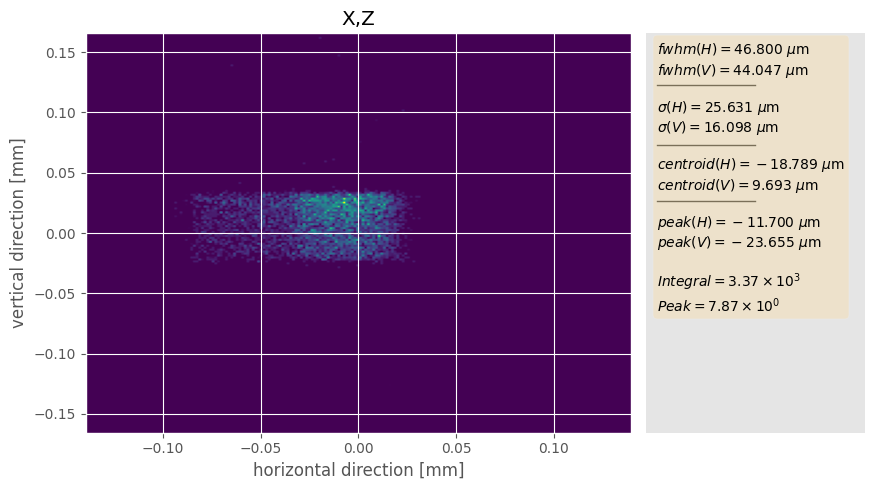

In [98]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[8.068679916808227]


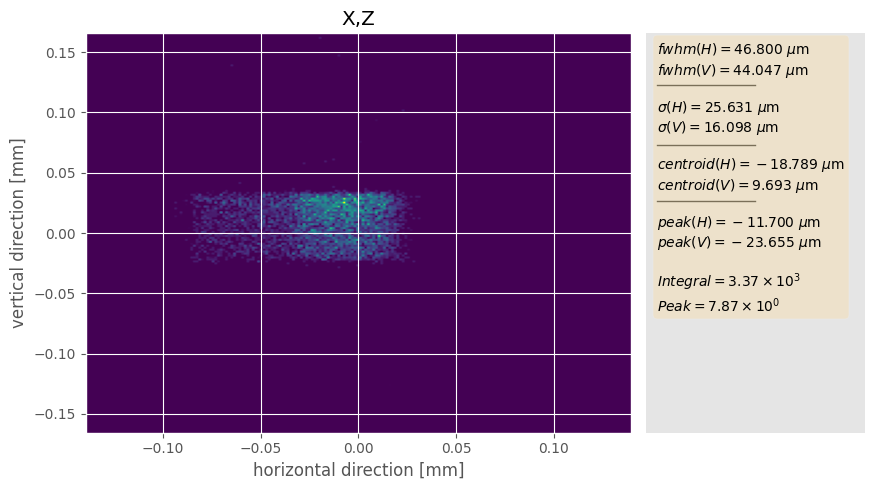

In [99]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

/tmp/ipykernel_3879159/1243347140.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

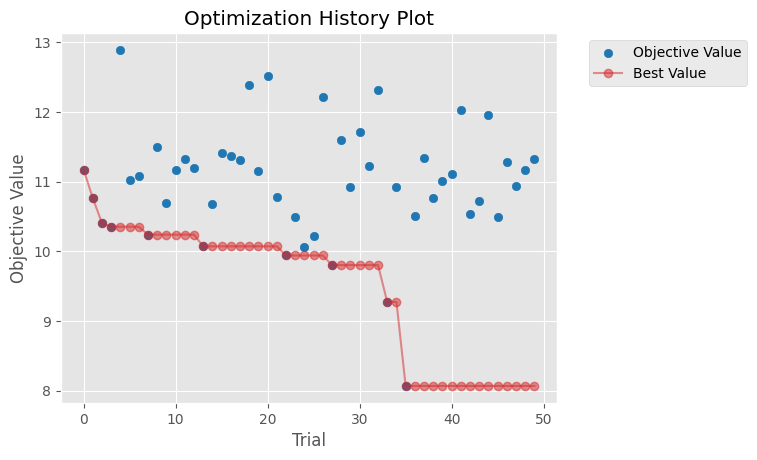

In [100]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)